# Solving satisfiability problems using Grover’s Algorithm- Trabalho Prático de Iteração e concorrência

Grupo:
   - Hugo Costeira a87976
   - João Silva a87939
   - João Goulart a82643

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_distribution
import matplotlib.pyplot as plt
import numpy as np

### Fórmula booleana utilizada

$$ f(v1,v2,v3) = (\neg v1 \lor \neg v2 \lor \neg v3) \wedge (v1 \lor \neg v2 \lor v3) \wedge (v1 \lor v2 \lor \neg v3) \wedge (v1 \lor \neg v2 \lor \neg v3) \wedge (\neg v1 \lor v2 \lor v3) \wedge (\neg v1 \lor v2 \lor \neg v3) \wedge  (v1 \lor v2 \lor v3) $$

$$ c1 = (\neg v1 \lor \neg v2 \lor \neg v3) $$

$$ c2 = (v1 \lor \neg v2 \lor v3) $$

$$ c3 = (v1 \lor v2 \lor \neg v3) $$

$$ c4= (v1 \lor \neg v2 \lor \neg v3) $$

$$ c5 = (\neg v1 \lor v2 \lor v3) $$

$$ c6 = (\neg v1 \lor v2 \lor \neg v3) $$

$$ c7 = (v1 \lor v2 \lor v3) $$



$v_1$ | $v_2$ | $v_3$ | $c_1$ | $c_2$ | $c_3$ | $c_4$ | $c_5$ | $c_6$ | $c_7$ | $f$
:---- | :---- | :---- | :---- | :---- | :---- | :---- | :---- | :---- | :---- | :--
  0   |   0   |   0   |   1   |   1   |   1   |   1   |   1   |   1   |   0   |  0 
  0   |   0   |   1   |   1   |   1   |   0   |   1   |   1   |   1   |   1   |  0 
  0   |   1   |   0   |   1   |   0   |   1   |   1   |   1   |   1   |   1   |  0 
  0   |   1   |   1   |   1   |   1   |   1   |   0   |   1   |   1   |   1   |  0 
  1   |   0   |   0   |   1   |   1   |   1   |   1   |   0   |   1   |   1   |  0 
  1   |   0   |   1   |   1   |   1   |   1   |   1   |   1   |   0   |   1   |  0 
  1   |   1   |   0   |   1   |   1   |   1   |   1   |   1   |   1   |   1   |  1 
  1   |   1   |   1   |   0   |   1   |   1   |   1   |   1   |   1   |   1   |  0 

### Execute_circuit
- Função que executa o circuito e devolve os resultados obtidos

In [2]:
def execute_circuit(qc, shots=1024, decimal=False):
    #define backend
    device = Aer.get_backend('qasm_simulator')
    #get counts
    counts = device.run(qc, shots=shots).result().get_counts()
    
    if decimal:
        counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
    else:
        counts = dict((a[::-1],b) for (a,b) in counts.items())

    return counts

### Difusion_operator
- Aplica o operador de difusão a um circuito quântico e devolve esse circuito

In [3]:
def diffusion_operator(qr, ancilla):
    qc = QuantumCircuit(qr,ancilla)
    
    qc.h(qr)
    qc.x(qr)
    qc.h(qr[-1])
    # controlos sao todos menos o ultimo qubit e o target é o ultimo
    qc.mcx(qr[:-1],qr[-1])
    qc.h(qr[-1])
    qc.x(qr)
    qc.h(qr)

    qc.barrier()
    return qc

### Oracle
- O argumento condicoes representa a fórmula, indicando para cada cláusula se esta deve ou não ser negada. Com isto, aplica-se, em cada cláusula, a gate x aos qubits que devem ser negados, a gate mcx aos 3 qubits originais e a gate x à ancilla da cláusula. Finalmente, aplica-se a gate mcx às ancillas de cada cláusula, usando a última ancilla como target.

In [4]:
def oracle(qr, ancilla, condicoes):
    qc = QuantumCircuit(qr, ancilla)
    clauses = len(condicoes)

    for k, condicao in enumerate(condicoes):
        for i in range(3):
            if not condicao[i]:
                qc.x(i)

        qc.mcx(qr, ancilla[k])
        qc.x(ancilla[k])

        for i in range(3):
            if not condicao[i]:
                qc.x(i)

        qc.barrier()
    qc.mcx(ancilla[:-1],ancilla[-1])
    qc.barrier()
    return qc

### Número de Iterações
A fórmula usada para o número de iterações ($i$) necessárias para o algortimos é

$i = \lfloor \frac{\pi}{4} \cdot \sqrt{N} \rfloor$


sendo $N$ uma potência de 2.

Neste caso como são 3 qubits, o número de elementos será 2^3=8.

Logo o número de iterações (i) será igual a 2

In [5]:
def grover(qc, qr, ancilla, oracle):
    elements = 2**3 #pois são 3 qubits

    iterations = int(np.floor(np.pi/4 * np.sqrt(elements)))

    for j in range(iterations):
        qc = qc.compose(oracle(qr, ancilla, condicoes))
        qc = qc.compose(diffusion_operator(qr, ancilla))
    return qc

Uma vez que não é possível utilizar o operador da disjunção em qubits, começou-se por reescrever a fórmula da seguinte forma:
$$ f(v1,v2,v3) = \neg (v1 \wedge v2 \wedge v3) \wedge \neg (\neg v1 \wedge v2 \wedge \neg v3) \wedge \neg (\neg v1 \wedge \neg v2 \wedge v3) \wedge \neg (\neg v1 \wedge v2 \wedge v3) \wedge \neg(v1 \wedge \neg v2 \wedge \neg v3) \wedge \neg( v1 \wedge \neg v2 \wedge v3) \wedge  \neg(\neg v1 \wedge \neg v2 \wedge \neg v3) $$

In [6]:
condicoes = [[True, True, True],
            [False, True, False],
            [False, False, True],
            [False, True, True],
            [True, False, False],
            [True, False, True],
            [False, False, False]]

### Init
- Definimos o circuito com  com o número de qubits necessários (3 bits inciais + 1 ancilla por cada cláusula + 1 ancilla final) e colocamos todos estes qubits em superposição uniforme ($|+\rangle $ nos bits iniciais e $|-\rangle $ nas ancillas)

In [7]:
def init(condicoes):
    qr = QuantumRegister(3)
    ancilla = QuantumRegister(len(condicoes) + 1)
    cr = ClassicalRegister(3)
    qc = QuantumCircuit(qr, ancilla, cr)

    qc.h(qr)
    qc.x(ancilla)
    qc.h(ancilla)
    qc.barrier()
    return qc, qr, ancilla, cr

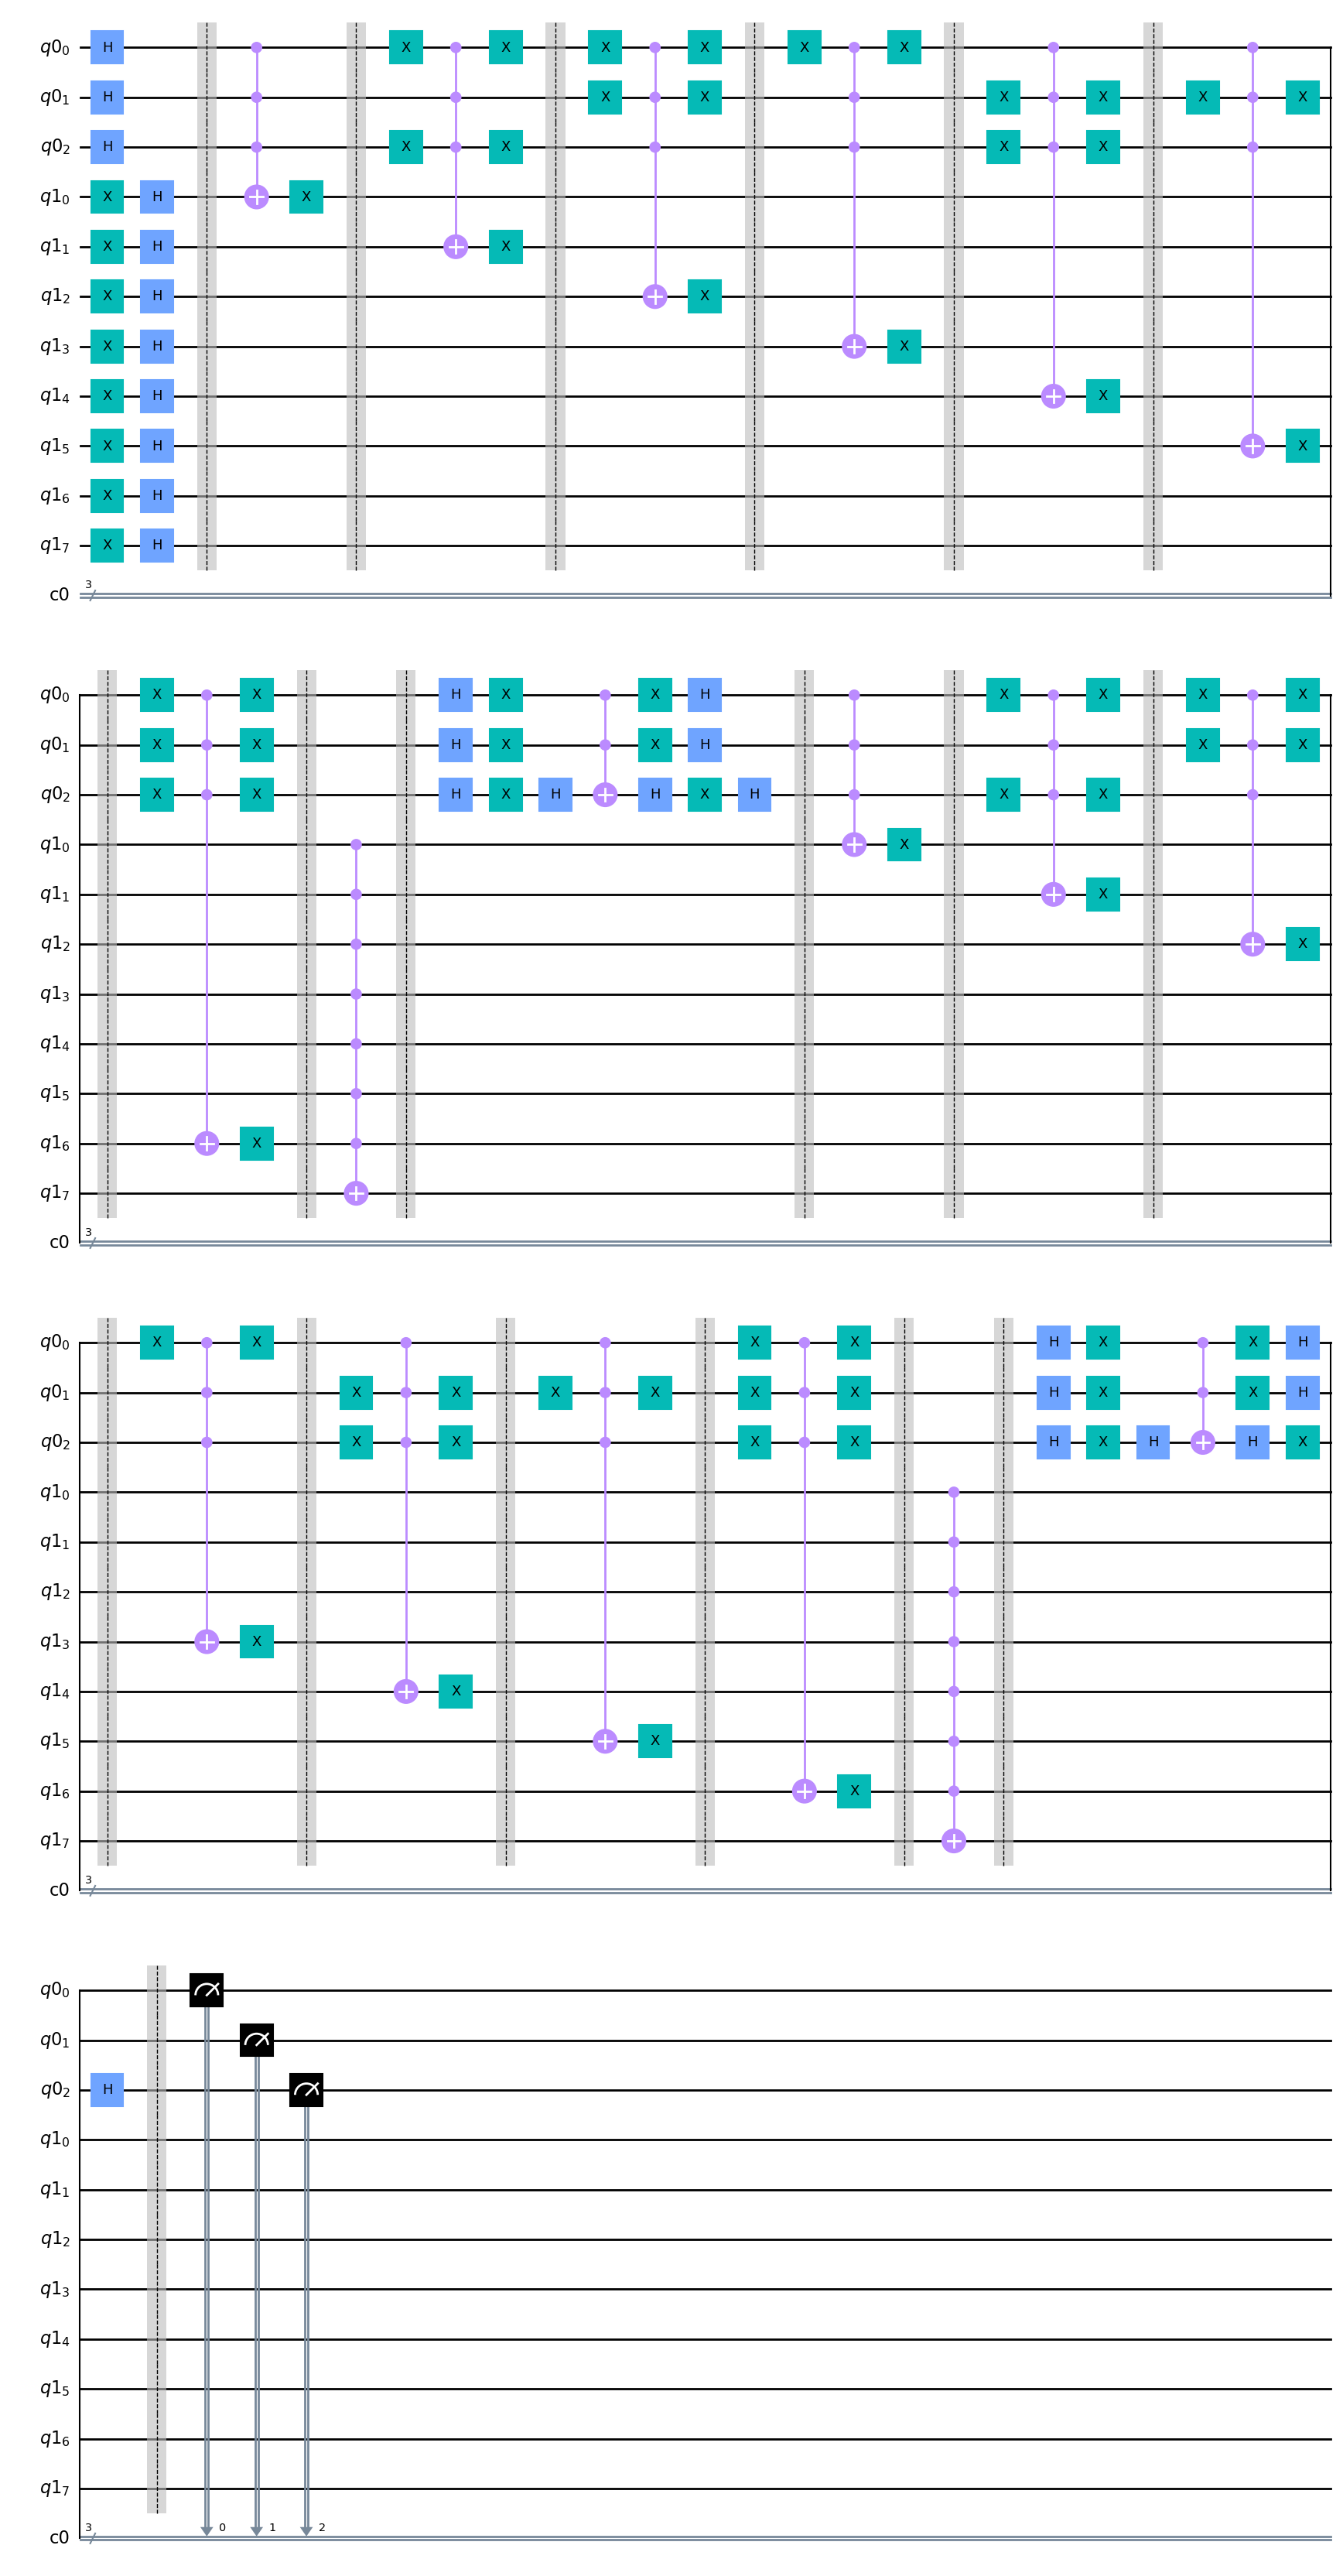

In [8]:
qc,qr,ancilla,cr=init(condicoes)
qc = grover(qc, qr, ancilla, oracle)
qc.measure(qr, cr)
qc.draw(output="mpl")

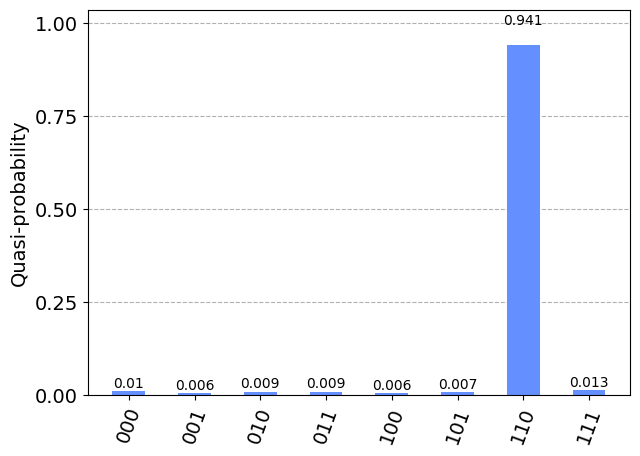

In [9]:
plot_distribution(execute_circuit(qc, shots=1024))

Como era esperado a solução é **110**

###  Avaliar a qualidade da solução empregada pelo algoritmo quântico

Retiramos a classe Verifier de uma das referências dadas pelo professor, que recebendo um ficheiro, nos irá indicar se uma solução é correta. Depois de executado, reparamos que é igual à solução obtida pelo circuito (**110**).

In [10]:
class Verifier():
    """Create an object that can be used to check whether
    an assignment satisfies a DIMACS file.
        Args:
            dimacs_file (str): path to the DIMACS file
    """
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        """Verifies a SAT solution against this object's
        DIMACS file.
            Args:
                guess (str): Assignment to be verified.
                             Must be string of 1s and 0s.
            Returns:
                bool: True if `guess` satisfies the
                           problem. False otherwise.
        """
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess][::-1]
        for line in self.dimacs.split('\n'):
            line = line.strip(' 0')
            clause_eval = False
            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if clause_eval is False:
                return False
        return True

In [11]:
ver = Verifier('my3SAT.dimacs')
sol_possible = ['000', '001', '010', '100', '011', '101', '110', '111']
for sol in sol_possible:
    res = "Possibilidade " + sol[::-1] + ": " + str(ver.is_correct(sol))
    print(res)

Possibilidade 000: False
Possibilidade 100: False
Possibilidade 010: False
Possibilidade 001: False
Possibilidade 110: True
Possibilidade 101: False
Possibilidade 011: False
Possibilidade 111: False
